iteration:0, cost:732.8506723283793 
iteration:1000, cost:87.10308618668634 
iteration:2000, cost:73.41212730463563 
iteration:3000, cost:66.24547107603888 
iteration:4000, cost:61.56893090369091 
iteration:5000, cost:58.1771339053744 
iteration:6000, cost:55.56299061483604 
iteration:7000, cost:53.46632433034011 
iteration:8000, cost:51.737193610521416 
iteration:9000, cost:50.28171031318273 
iteration:10000, cost:49.0371220925679 
iteration:11000, cost:47.959296871195164 
iteration:12000, cost:47.01597453071303 
iteration:13000, cost:46.182876352690045 
iteration:14000, cost:45.44131750755092 
iteration:15000, cost:44.77666020073836 
iteration:16000, cost:44.17726637784526 
iteration:17000, cost:43.63376406361525 
iteration:18000, cost:43.138519878233325 
iteration:19000, cost:42.685252104522085 
iteration:0, cost:732.8506723283793 
iteration:1000, cost:88.37619078692364 
iteration:2000, cost:75.81238352922644 
iteration:3000, cost:69.57312046320001 
iteration:4000, cost:65.739734703

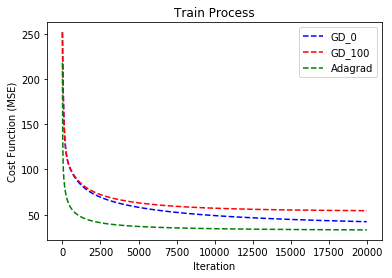

        Adagrad   CloseForm          GD
0     25.499374   25.326107   24.531581
1     64.515521   63.515251   61.861876
2     19.105968   18.896888   22.153480
3     28.864264   29.199515   29.191095
4      9.304041    9.207689    9.790288
5     31.640397   33.519127   26.184156
6     41.301934   40.977873   41.214896
7     16.848547   18.185740   16.771014
8     51.533946   52.684518   51.186428
9     32.729079   32.306145   29.943902
10    37.909730   38.442188   37.860072
11    58.802470   58.998259   55.112721
12    35.423959   35.424652   37.342447
13    40.010671   41.680323   32.028960
14    28.275320   26.426911   29.882046
15    12.197928   12.980885   11.340054
16    51.370157   52.012879   53.598625
17    23.114573   23.946533   21.489042
18    16.595098   18.303775   13.529535
19    18.211726   19.351959   15.223443
20    15.532185   15.896276   17.769975
21    30.144342   31.436335   30.391107
22    39.519717   39.251822   38.944816
23    10.137274   11.178215   12.426782


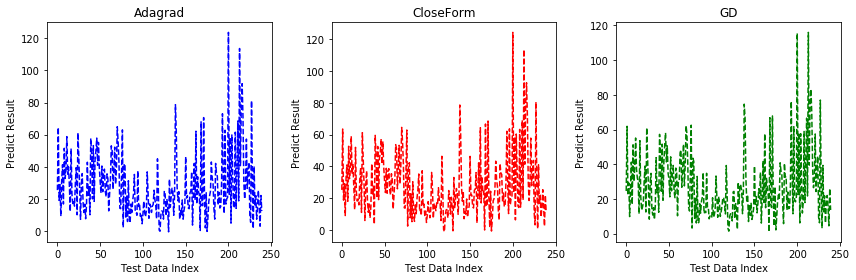

In [7]:
import numpy as np
import csv, os
from numpy.linalg import inv
import matplotlib.pyplot as plt
import pandas as pd


# gradient decent
def GD(X, Y, W, eta, Iteration, lambdaL2):
    """
    使用gradient decent learning rate 要調很小，不然很容易爆炸
    """
    listCost = []
    for itera in range(Iteration):
        arrayYHat = X.dot(W)
        arrayLoss = arrayYHat - Y
        arrayCost = (np.sum(arrayLoss**2) / X.shape[0])
        listCost.append(arrayCost)

        arrayGradient = (X.T.dot(arrayLoss) / X.shape[0]) + (lambdaL2 * W)
        W -= eta * arrayGradient
        if itera % 1000 == 0:
            print("iteration:{}, cost:{} ".format(itera, arrayCost))
    return W, listCost


# Adagrad
def Adagrad(X, Y, W, eta, Iteration, lambdaL2):
    listCost = []
    arrayGradientSum = np.zeros(X.shape[1])
    for itera in range(Iteration):
        arrayYHat = np.dot(X, W)
        arrayLoss = arrayYHat -Y
        arrayCost = np.sum(arrayLoss**2) / X.shape[0]

        # save cost function value in process
        listCost.append(arrayCost)

        arrayGradient = (np.dot(np.transpose(X), arrayLoss) / X.shape[0]) + (lambdaL2 * W)
        arrayGradientSum += arrayGradient**2
        arraySigma = np.sqrt(arrayGradientSum)
        W -= eta * arrayGradient / arraySigma

        if itera % 1000 == 0:
            print("iteration:{}, cost:{} ".format(itera, arrayCost))
    return W, listCost


###---DataProcessing---###
# 給定資料空間
listTrainData = []
for i in range(18):
	listTrainData.append([])

# 將資料放進空間
textTrain = open(os.path.join(os.path.dirname('__file__'), "01-数据集/train.csv"), "r", encoding="big5") 
rowTrain = csv.reader(textTrain)
n_row = 0
for r in rowTrain:
    if n_row != 0:
        for i in range(3, 27):
            if r[i] != "NR":
                listTrainData[(n_row-1) % 18].append(float(r[i]))
            else:
                listTrainData[(n_row-1) % 18].append(float(0))   
    n_row += 1    
textTrain.close()

listTrainX = []
listTrainY = []
# 將資料拆成 x 和 y
for m in range(12):
    # 一個月每10小時算一筆資料，會有471筆
    for i in range(471):
        listTrainX.append([])
        listTrainY.append(listTrainData[9][480*m + i + 9])
        # 18種汙染物
        for p in range(18):
        # 收集9小時的資料
            for t in range(9):
                listTrainX[471*m + i].append(listTrainData[p][480*m + i + t])

listTestData = []
textTest = open(os.path.join(os.path.dirname('__file__'), "01-数据集/test.csv"), "r", encoding="big5")
rowTest = csv.reader(textTest)
n_row = 0
for r in rowTest:
    if n_row % 18 == 0:
        listTestData.append([])
        for i in range(2, 11):
            listTestData[n_row // 18].append(float(r[i]))
    else:
        for i in range(2, 11):
            if r[i] == "NR":
                listTestData[n_row // 18].append(float(0))
            else:
                listTestData[n_row // 18].append(float(r[i]))
    n_row += 1
textTest.close()

arrayTestX = np.array(listTestData)
arrayTrainX = np.array(listTrainX)
arrayTrainY = np.array(listTrainY)


###---Train---###
# 增加bias項
arrayTrainX = np.concatenate((np.ones((arrayTrainX.shape[0], 1)), arrayTrainX), axis=1) # (5652, 163)

# gradient decent
intLearningRate = 1e-6
arrayW = np.zeros(arrayTrainX.shape[1])  # (163, )
arrayW_gd, listCost_gd = GD(X=arrayTrainX, Y=arrayTrainY, W=arrayW, eta=intLearningRate, Iteration=20000, lambdaL2=0)
arrayW = np.zeros(arrayTrainX.shape[1])  # (163, )
arrayW_gd_1, listCost_gd_1 = GD(X=arrayTrainX, Y=arrayTrainY, W=arrayW, eta=intLearningRate, Iteration=20000, lambdaL2=100)
# Adagrad
intLearningRate = 5
arrayW = np.zeros(arrayTrainX.shape[1])  # (163, )
arrayW_ada, listCost_ada = Adagrad(X=arrayTrainX, Y=arrayTrainY, W=arrayW, eta=intLearningRate, Iteration=20000, lambdaL2=0)
# close form
arrayW_cf = inv(arrayTrainX.T.dot(arrayTrainX)).dot(arrayTrainX.T.dot(arrayTrainY))


###---Test---###
arrayTestX = np.concatenate((np.ones((arrayTestX.shape[0], 1)), arrayTestX), axis=1)  # (240, 163)

# gradient decent
arrayPredictY_gd = np.dot(arrayTestX, arrayW_gd)
# Adagrad
arrayPredictY_ada = np.dot(arrayTestX, arrayW_ada)
# close form
arrayPredictY_cf = np.dot(arrayTestX, arrayW_cf)

###---Visualization---###
plt.plot(np.arange(len(listCost_gd[3:])), listCost_gd[3:], "b--", label="GD_0")
plt.plot(np.arange(len(listCost_gd_1[3:])), listCost_gd_1[3:], "r--", label="GD_100")
plt.plot(np.arange(len(listCost_ada[3:])), listCost_ada[3:], "g--", label="Adagrad")
plt.title("Train Process")
plt.xlabel("Iteration")
plt.ylabel("Cost Function (MSE)")
plt.legend()
plt.savefig(os.path.join(os.path.dirname('__file__'), "02-输出/TrainProcess"))
plt.show()

# compare predict value with different methods
dcitD = {"Adagrad":arrayPredictY_ada, "CloseForm":arrayPredictY_cf, "GD":arrayPredictY_gd}
pdResult = pd.DataFrame(dcitD)
pdResult.to_csv(os.path.join(os.path.dirname('__file__'), "02-输出/Predict"))
print(pdResult)

# visualize predict value with different methods
plt.figure(figsize=(12, 4))
plt.subplot(131)
plt.plot(np.arange(len(arrayPredictY_ada)), arrayPredictY_ada, "b--")
plt.title("Adagrad")
plt.xlabel("Test Data Index")
plt.ylabel("Predict Result")
plt.subplot(132)
plt.plot(np.arange(len(arrayPredictY_cf)), arrayPredictY_cf, "r--")
plt.title("CloseForm")
plt.xlabel("Test Data Index")
plt.ylabel("Predict Result")
plt.subplot(133)
plt.plot(np.arange(len(arrayPredictY_gd)), arrayPredictY_gd, "g--")
plt.title("GD")
plt.xlabel("Test Data Index")
plt.ylabel("Predict Result")
plt.tight_layout()
plt.savefig(os.path.join(os.path.dirname('__file__'), "02-输出/Compare"))
plt.show()